In [1]:
import os
import pandas as pd

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

a=%pwd # 현재 경로 a에 할당
os.chdir(a) # 파일 로드 경로 설정

# 참조 데이터가 필요한 경우
---
- 도로명 주소, 지번주소, 회원명, 회원 번호 등의 데이터는 보통 `일정한 패턴` 이 없고, 포맷도 다른 경우가 많다.
- 이런 경우 `참조 데이터` 를 활용해서 변경한 뒤 merge를 하여 데이터 병합을 할 수 있다.
---
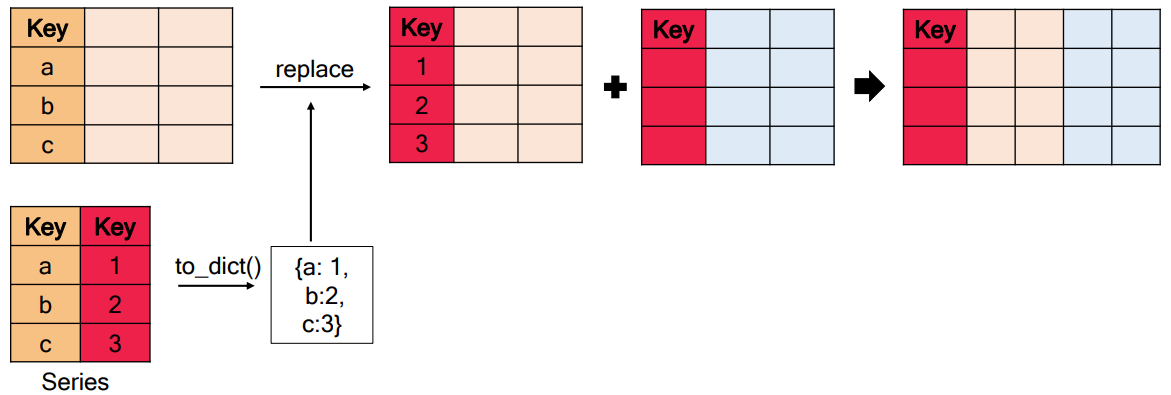

---
e.g) 병합하고자 하는 데이터의 key값이 다른 경우
- a, b, c라고 되어있는 key값을 참조데이터를 활용해 각각 1, 2, 3으로 변경한 뒤에 merge를 진행한다.

# 관련 문법 1 : Series.to_dict()
---

- Series의 index를 Key로, Data를 Value로 하는 dict형태로 변환해주는 함수
- replace 등 사전을 입력받는 함수를 사용할때 주로 사용하는 함수이다.
- index랑 Data가 매칭되는 점을 유의 해야 함
    - 일반적으로 참조 데이터를 불러올때, data의 type가 Series가 아니라 DataFrame인 경우가 있다.
    - 이 경우 DataFrame에서 index와 Data를 설정해준 뒤에 dict로 바꿔줘야 한다.
---
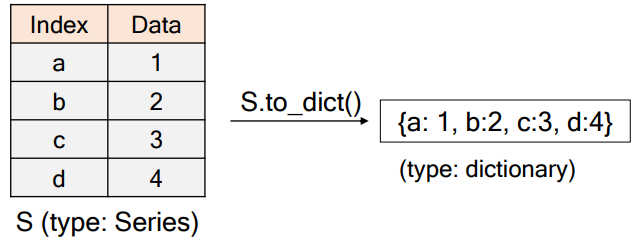

# 관련 문법 2 : Series.replace()
---
- dict를 입력받아, Series 내에 있는 요소 가운데 key와 같은 값을 value로 변환해주는 함수
- 'S' 라는 데이터의 value들을 변환해야 하는데, 아래 그림과 같은 dict를 replace()에 입력해주면, 이를 참조해서 값이 변경된다.

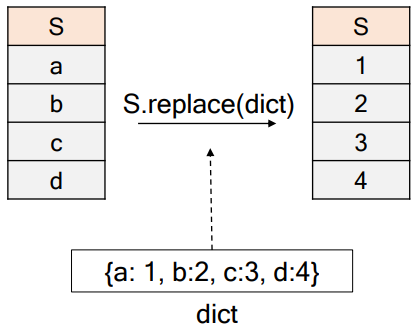

---
- If, 'S' 데이터에 'e'라는 값이 있다면 (dict에는 'e'에 대한 참조 데이터가 없다), 이때의 결과값은 a~d는 dict가 반영된 위의 그림과 같이 결과가 나오고, e는 기존 S에 있던 값이 그대로 나오게 된다.

# 참조데이터를 통한 merge 실습

**2011년 '군' 이었 것들이 '시'로 변경되어 데이터에 이를 적용하고자 할때**

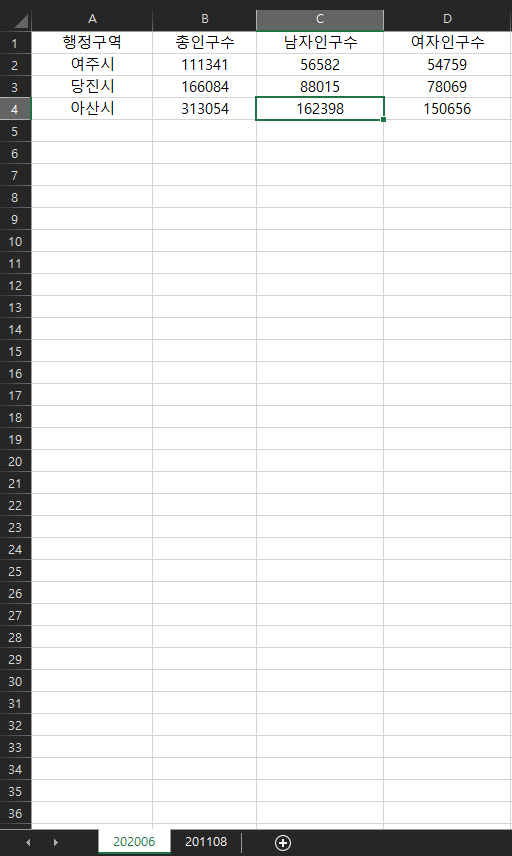

---

**Tip.** Data를 load할때, 원본 파일이 열려있으면 'Permission denied' 라고 경고가 뜰 수 있다.

In [2]:
# 데이터 불러오기
# read_csv로 불러온 파일은 항상 'DataFrame' 이다.

ref_df = pd.read_csv("시승격정보.csv", encoding = "cp949")  #참고할 데이터

# sheet_name 파라미터를 활용해 특정 sheet의 값만 불러올 수도 있다.
df1 = pd.read_excel("인구수데이터.xlsx", sheet_name = "202006") #2020년 데이터
df2 = pd.read_excel("인구수데이터.xlsx", sheet_name = "201108") #2011년 데이터

In [3]:
ref_df

,승격전,승격후,승격날짜
0,여주군,여주시,2013년 09월 23일
1,당진군,당진시,2012년 01월 01일


In [4]:
df1

,행정구역,총인구수,남자인구수,여자인구수
0,여주시,111341,56582,54759
1,당진시,166084,88015,78069
2,아산시,313054,162398,150656


In [5]:
df2

,행정구역,총인구수,남자인구수,여자인구수
0,여주군,109019,55122,53897
1,아산시,271356,138150,133206
2,당진군,148175,76555,71620


## Series 형태로 type 변경
---
- reference 데이터가 데이터 프레임 형태이기 때문에 to_dict()하기 위해 Series형태로 변경시켜줘야 한다.
- Series의 index가 key가 되고, data가 value가 되도록 해야 한다 -> set_index를 활용해 '승격전' 컬럼을 인덱스로 설정


In [6]:
# index가 승격전이고, 데이터가 승격후인 Series
# set_index를 활용해 '승격전' 컬럼을 인덱스로 설정
ref_df.set_index('승격전')['승격후']

승격전
여주군    여주시
당진군    당진시
Name: 승격후, dtype: object

인덱스 자료를 기반으로 대응되는 '승전후'값을 dict형태로 바꿔준다.

In [7]:
# 인덱스 설정 및 시리즈로 변환
ref_dict = ref_df.set_index('승격전')['승격후'].to_dict()

In [8]:
df2['행정구역'] #행정구역이 '군'으로 표기 되어 있다.

0    여주군
1    아산시
2    당진군
Name: 행정구역, dtype: object

ref_dict을 이용하여 키 변수 값 변환

In [9]:
# 2011년의 행정구역명(df2)을 ref_dict를 참조하여 2020의 행정구역명(df1)으로 replace하는 것.

df2['행정구역'] = df2['행정구역'].replace(ref_dict)
df2['행정구역']
#행정구역이 '시'로 변경 된다.

0    여주시
1    아산시
2    당진시
Name: 행정구역, dtype: object

## merge
---
- df1과 df2에 있는 `변수명이 모두 같으므로`, 두 연도간의 데이터를 구분하기 위해 변수명 변경을 해줄 필요가 있다.

In [10]:
df1.set_index("행정구역", inplace = True) # 행정 구역 변수명은 바꾸지 않기 위해, 인덱스로 설정
df2.set_index("행정구역", inplace = True) # 행정 구역 변수명은 바꾸지 않기 위해, 인덱스로 설정

### add_prefix() 함수로 데이터 구분하기
---

- 모든 컬럼에 접두사를 붙여주는 add_prefix() 함수를 활용해 2020년 데이터와 2011데이터를 구분해준다.
- add_prefix()를 쓰면 '모든 컬럼에 일괄적용' 되기때문에 merge()에 활용할 '행정구역'은 index화 시켜 영향을 받지 않게 하였다.

In [11]:
# 위에서 데이터 load할때의 sheet명을 prefix명으로 활용
df1 = df1.add_prefix("202006_") 
df2 = df2.add_prefix("201108_")

In [12]:
# 각각의 데이터 프레임의 인덱스를 kye인덱스로 사용하기 위해 left_index = True, right_index = True를 적용
merged_df = pd.merge(df1, df2, left_index = True, right_index = True)

In [13]:
merged_df.head()

,202006_총인구수,202006_남자인구수,202006_여자인구수,201108_총인구수,201108_남자인구수,201108_여자인구수
행정구역,,,,,,
여주시,111341,56582,54759,109019,55122,53897
당진시,166084,88015,78069,148175,76555,71620
아산시,313054,162398,150656,271356,138150,133206
